In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.rollout import ROLLOUT
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 1. load data

In [2]:
dataset_name = 'cnn'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [process_str(item['article']) for item in train_dataset]
    train_highlights = [process_str(item['highlights']) for item in train_dataset]
    val_articles = [process_str(item['article']) for item in val_dataset]
    val_highlights = [process_str(item['highlights']) for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 24.2 s, sys: 611 ms, total: 24.8 s
Wall time: 28.3 s


In [4]:
indices = []
for i in range(len(train_articles)):
    if len(train_articles[i]) < 2500:
        indices.append(i)
print(len(indices))
print(len(train_articles))
train_articles = list(np.array(train_articles)[indices])
train_highlights = list(np.array(train_highlights)[indices])

indices = []
for i in range(len(val_articles)):
    if len(val_articles[i]) < 2500:
        indices.append(i)
        
val_articles = list(np.array(val_articles)[indices])
val_highlights = list(np.array(val_highlights)[indices])

66414
287113


### 2. sentencepiece model

In [5]:
train_new_model = False

In [6]:
%%time
if train_new_model:
    with open('data/cnn_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/cnn_texts.txt',
                                   model_prefix='cnn10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 µs


### 3. dataset and dataloaders

In [7]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/cnn{int(vocab_size/1000)}k.model'

In [8]:
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [9]:
batch_size = 4
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                            collate_fn=Padder(), shuffle=True)

### 4. model architecture

In [11]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:1


In [12]:
writer = SummaryWriter()

In [13]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)

### 5. generator pretraining

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 1e-4
opt = torch.optim.Adam(G.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5)
start_teacher_forcing = 0.5
teacher_forcing_decay = 0.025
n_epochs = 50

epoch_losses = []
val_losses = []
iter_num = -1

In [ ]:
for epoch_idx in range(n_epochs):
    G.train()
    total_loss = 0.
    teacher_forcing = start_teacher_forcing - epoch_idx*teacher_forcing_decay
    for batch_idx, data_input in tqdm(enumerate(train_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        opt.zero_grad()
        out = G(article, highlight, teacher_forcing_ratio=teacher_forcing)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1)
        iter_num += 1
        if iter_num % 1000 == 0:
            writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset))
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    val_loss = total_loss / len(val_dataset)
    val_losses.append(val_loss)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    
    scheduler.step(val_loss)
    print(f'current lr {get_lr(opt)}')
    print(f'current teacher forcing: {teacher_forcing}')
    
    indices = sps.randint(0, out.size(1)).rvs(size=4)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        print(f'predicted: {pred}')
        print(f'truth: {truth}\n')

8682it [29:34,  5.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

16604it [56:42,  4.88it/s]
2it [00:00, 16.46it/s]

epoch 1 train loss: 6.550945527616668


907it [01:00, 14.98it/s]


epoch 1 val loss: 6.8607014984122445
current lr 0.0001
current teacher forcing: 0.475


1it [00:00,  5.35it/s]

predicted: manchester united hasedededed in the in the the the the the the the the the the the the the the the the the the the the the the the the the the the the
truth: tomasz kucz to spend a week with manchester united on trial poland goalkeeper is wanted by several top clubs after impressing for u15s liverpool rangers and bayer leverkusen have offered the youngster trials fulham and everton are also interested in the 15 year old stopper click here for all the latest manchester united news

predicted: manchester united hasededed to the in the in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
truth: manchester city paid the price against burnley admits jesus navas manuel pellegrini s side fellow to 1 0 defeat at turf moor on saturday george boyd scored as city s title chances suffered a serious blow

predicted: thesssss the thes in the the the the the the the the the the the the the the the the the the th

16604it [56:38,  4.89it/s]
2it [00:00, 13.73it/s]

epoch 2 train loss: 6.414966688406845


907it [01:00, 15.10it/s]


epoch 2 val loss: 6.786892848871772
current lr 0.0001
current teacher forcing: 0.45


1it [00:00,  5.94it/s]

predicted: manchester united hasedededed in the in the the the the the the the theed the the the the the the the the the the the the the the the the the the
truth: former newcastle midfielder yohan cabaye will travel to stamford bridge the frenchman has been sidelined with a groin injury since february 14 psg will however be missing winger lucas and defender serge aurier

predicted: police say theededededed in the in in the in the the the theed the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
truth: the dog called cabela was shot twice in the neck and once in the shoulder injuries were so severe its front right leg will be amputated in coming days police arrived in sulphur springs area after three calls of shots being fired they are asking for public s help to hunt down culprit and the dog s owner

predicted: thesssssssssssssssssssssssssssssssssssssssssssssssssssss
truth: woolworths give away the dominoes with every

16604it [56:21,  4.91it/s]
2it [00:00, 13.04it/s]

epoch 3 train loss: 6.316066002211791


907it [00:58, 15.38it/s]


epoch 3 val loss: 6.725425946804497
current lr 0.0001
current teacher forcing: 0.425


0it [00:00, ?it/s]

predicted: manchester city hasededed to the the for the season the the the the the the the the the the the the the the the the the the the the the the the the the the the the
truth: alexis sanchez is currently away with chile on international duty chile play iran in st polten on thursday and brazil in london on sunday the arsenal forward has scored 19 goals for the gunners this season click here for all the latest arsenal news

predicted: manchester city hasededed to the the for the season the the the the the the the the the the the the the the the the the the the the the the the the the the the the
truth: alexis sanchez is currently away with chile on international duty chile play iran in st polten on thursday and brazil in london on sunday the arsenal forward has scored 19 goals for the gunners this season click here for all the latest arsenal news

predicted: thessed the the in the in the in the the the the the the the the the the the the the the the the the the the the the the the 

16604it [56:57,  4.86it/s]
2it [00:00, 14.75it/s]

epoch 4 train loss: 6.248036321400555


907it [00:59, 15.35it/s]


epoch 4 val loss: 6.65902082449546
current lr 0.0001
current teacher forcing: 0.4


1it [00:00,  5.59it/s]

predicted: the was wasedededed in in in in in he wasedededed in the he waseded to theed to the he waseded to theed to theed to the he waseded to theed to the the he waseded to theed to the
truth: killer simon hennessey jailed after 15 years on the run in australia serving life sentence for manslaughter when walked out of open prison 50 year old arrested 15 years later by officers probing credit card fraud hennessey was using stolen identity of man left brain damaged in smash after serving five and a half years in jail in australia deported back to uk judge jails hennessey for a further 16 months for evading lawful custody

predicted: the was wasedededed in in in in in he wasedededed in the he waseded to theed to the he waseded to theed to theed to the he waseded to theed to the the he waseded to theed to the
truth: killer simon hennessey jailed after 15 years on the run in australia serving life sentence for manslaughter when walked out of open prison 50 year old arrested 15 years late

16604it [56:58,  4.86it/s]
2it [00:00, 14.51it/s]

epoch 5 train loss: 6.196326683052016


907it [00:58, 15.54it/s]


epoch 5 val loss: 6.617648491654402
current lr 0.0001
current teacher forcing: 0.375


0it [00:00, ?it/s]

predicted: theyy was wasededed her in in in in in in hers she waseded hered the her and hered the the the the the the the theed the the the the the the the the the theed the the
truth: keyanna rivera went into labor at her doctor s office her doctor dr devalla was a few miles away finishing surgery using app dr devalla was able to help her assistants through the delivery

predicted: bayern munich beats 1 0 in the in in in in in the the the the the the the the the in the in the in the the the the the the the the the in the in the in the thes the in the the
truth: seven french coaches travelled to bayern munich for three days zinedine zidane joined willy sagnol claude makelele guy lacombe bernard diomede claude le roy and franck thivillier they watched pep guardiola take training of the bundesliga champions

predicted: thesssssssssssssssssssssssssssssssssssssss
truth: volcano shoots ash into the atmosphere some 30 000 feet winds blow ash cloud across the bering sea and into western alask

14437it [49:28,  4.22it/s]

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('generator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
save_path = 'saved_models/pretrained_seq2seq_gen_4.pth'
torch.save(G.state_dict(), save_path)

### 6. discriminator pretraining

In [14]:
save_path = 'saved_models/pretrained_seq2seq_gen_3.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
G.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [16]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)

In [18]:
criterion = nn.BCELoss()
lr = 1e-4
opt = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 2

epoch_losses = []
val_losses = []
iter_num = -1
writer = SummaryWriter()

In [19]:
for epoch_idx in range(n_epochs):
    D.train()
    total_loss = 0.
    
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        opt.zero_grad()
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    D.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        total_loss += loss.data.item() * article.size(1) * 2

    val_losses.append(total_loss / len(val_dataset) / 2)
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [00:44, 12.18it/s]
2it [00:00, 14.04it/s]

epoch 0 train loss: 0.23779804286710338


231it [00:16, 14.16it/s]
2it [00:00, 11.64it/s]

epoch 0 val loss: 0.031208537723029284


539it [00:43, 12.32it/s]
2it [00:00, 13.94it/s]

epoch 1 train loss: 0.06076200075888883


231it [00:16, 14.15it/s]

epoch 1 val loss: 0.005752120049201727


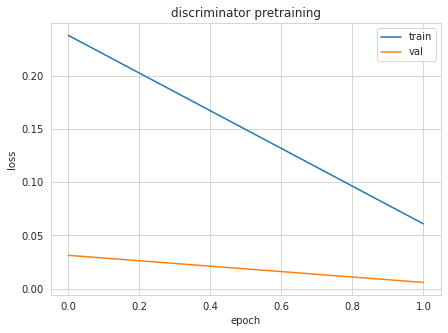

In [22]:
plt.figure(figsize=(7, 5))
plt.title('discriminator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
save_path = 'saved_models/pretrained_dis3.pth'
torch.save(D.state_dict(), save_path)

### 7. adversarial training

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
vocab_size = 10000
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/pretrained_seq2seq_gen_3.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/pretrained_dis3.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
n_epochs = 30
rollout_num = 2
beta = 0.8

In [16]:
writer = SummaryWriter()

In [17]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [18]:
D.train()

CNNDiscriminator(
  (embed): Embedding(10000, 256, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 256), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 256), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(3, 256), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
)

In [ ]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion_ml = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, 'min', patience=5)

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        '''
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        '''
        iter_num += 1
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        gen_out = G.sample(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rollout_func = ROLLOUT(G)
        rewards = rollout_func.get_reward(article, generated_highlight, rollout_num, D)
        # rewards = 1 - rewards
        writer.add_scalar('Reward/train', rewards.mean().data.item(), iter_num)
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=0.)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss_train/loss', loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/ml_loss', ml_loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/pg_loss', pg_loss.data.item(), iter_num)
        total_G_loss += loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    total_reward = 0.
    total_ml_loss = 0.
    total_pg_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rollout_func = ROLLOUT(G)
        rewards = rollout_func.get_reward(article, generated_highlight, rollout_num, D)
        # rewards = 1 - rewards
        total_reward += rewards.mean().data.item() * article.size(1)
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=0.)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        total_loss += loss.data.item() * article.size(1)
        
        total_ml_loss += ml_loss.data.item() * article.size(1)
        total_pg_loss += pg_loss.data.item() * article.size(1)
    writer.add_scalar('Reward/val', total_reward / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/loss', total_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/ml_loss', total_ml_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/pg_loss', total_pg_loss / len(val_dataset), iter_num)
    
    scheduler.step(total_loss)
    
    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    # writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    
    indices = sps.randint(0, out.size(1)).rvs(size=10)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        print(f'predicted: {pred}')
        print(f'truth: {truth}\n')

248it [06:51,  1.71s/it]

In [21]:
save_path = 'saved_models/dis4_adv.pth'
torch.save(D.state_dict(), save_path)

save_path = 'saved_models/gen4_adv.pth'
torch.save(G.state_dict(), save_path)